# Confidence Interval

In [ ]:
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle
import numpy as np
from tqdm import tqdm
import plotly.graph_objs as go
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Data Preprocessing

In [2]:
df = pd.read_csv('../Data/STAGE 4 FINAL MERGED DATA/STAGE_4_MERGED_FINAL_ENCODED.csv')

In [3]:
df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,maks_penjara_berdasarkan_pasal,terdakwa,summarized_dakwaan,total_pidana_penjara_bulan
0,0,0,0,6,80,GEDE DARMAYASA,Terdakwa Gede Darmayasa didakwa telah melakuka...,5.0
1,1,1,1,4,48,IDA BAGUS MADE DARMA WIGUNA,"Pada bulan Februari dan Maret 2024, terdakwa I...",24.0
2,0,0,2,6,84,HANDRI JOHANAS,"Terdakwa Handri Johanes pada Rabu, 24 April 20...",4.0
3,2,2,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
4,2,3,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
...,...,...,...,...,...,...,...,...
4318,2,269,118,2,240,NURUL FIQRI SUDIRMAN als KIKI bin SUDIRMAN,"Pada Jumat, 31 Maret 2023, sekitar pukul 20.30...",72.0
4319,0,257,107,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4320,0,280,107,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4321,0,257,107,2,84,ANWAR RURI BIN SYARIFUDIN USMAN,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0


In [4]:
def stratified_split(df: pd.DataFrame, split_size: float = 0.8) -> tuple[pd.DataFrame, pd.DataFrame]:
    unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()
    
    print(unique_groups)
    train_idx, test_idx = [], []
    
    for indices in unique_groups.values():        
        if len(indices) == 1:
            train_idx.extend(indices)
        else:
            train, test = train_test_split(indices, train_size=split_size, random_state=42)
            train_idx.extend(train)
            test_idx.extend(test)
    
    return df.loc[train_idx], df.loc[test_idx]

train_df, test_df = stratified_split(df)

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


{(0, 0, 0): [0, 20, 42], (0, 0, 2): [2], (0, 1, 0): [19, 37], (0, 1, 4): [35, 36], (0, 4, 1): [5], (0, 4, 3): [10], (0, 5, 21): [843], (0, 7, 1): [9], (0, 8, 0): [15, 17], (0, 9, 0): [16, 18], (0, 11, 4): [22, 23], (0, 12, 19): [775, 776, 813], (0, 12, 21): [774], (0, 12, 22): [715], (0, 12, 23): [806], (0, 13, 0): [32], (0, 13, 3): [34], (0, 14, 0): [38], (0, 14, 14): [437, 501, 595, 609], (0, 14, 16): [422], (0, 14, 18): [474, 665], (0, 14, 19): [783, 784, 785, 786], (0, 14, 20): [432, 438, 518, 578, 608, 724, 745], (0, 14, 21): [639, 822], (0, 15, 4): [33], (0, 16, 0): [39], (0, 17, 0): [40, 41], (0, 19, 7): [46], (0, 20, 36): [1051], (0, 21, 52): [1612], (0, 21, 54): [1630, 1632], (0, 22, 10): [241, 268, 269, 270, 271, 303], (0, 22, 14): [259, 381, 415, 416, 538, 545, 577, 621], (0, 22, 16): [308, 314, 315, 383, 386, 417], (0, 22, 18): [654, 655, 656], (0, 22, 19): [548, 762], (0, 22, 20): [446, 570, 571, 572, 573, 690, 725], (0, 22, 22): [719], (0, 23, 10): [52, 54], (0, 24, 10): 

In [5]:
train_df, test_df = stratified_split(df)

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


{(0, 0, 0): [0, 20, 42], (0, 0, 2): [2], (0, 1, 0): [19, 37], (0, 1, 4): [35, 36], (0, 4, 1): [5], (0, 4, 3): [10], (0, 5, 21): [843], (0, 7, 1): [9], (0, 8, 0): [15, 17], (0, 9, 0): [16, 18], (0, 11, 4): [22, 23], (0, 12, 19): [775, 776, 813], (0, 12, 21): [774], (0, 12, 22): [715], (0, 12, 23): [806], (0, 13, 0): [32], (0, 13, 3): [34], (0, 14, 0): [38], (0, 14, 14): [437, 501, 595, 609], (0, 14, 16): [422], (0, 14, 18): [474, 665], (0, 14, 19): [783, 784, 785, 786], (0, 14, 20): [432, 438, 518, 578, 608, 724, 745], (0, 14, 21): [639, 822], (0, 15, 4): [33], (0, 16, 0): [39], (0, 17, 0): [40, 41], (0, 19, 7): [46], (0, 20, 36): [1051], (0, 21, 52): [1612], (0, 21, 54): [1630, 1632], (0, 22, 10): [241, 268, 269, 270, 271, 303], (0, 22, 14): [259, 381, 415, 416, 538, 545, 577, 621], (0, 22, 16): [308, 314, 315, 383, 386, 417], (0, 22, 18): [654, 655, 656], (0, 22, 19): [548, 762], (0, 22, 20): [446, 570, 571, 572, 573, 690, 725], (0, 22, 22): [719], (0, 23, 10): [52, 54], (0, 24, 10): 

In [6]:
model_scenario_name = "BiLSTM_12"
max_len = 1024

model_save_path = f'../Model/{model_scenario_name}'
tokenizer_save_path = f'../Model/{model_scenario_name}_tokenizer.pkl'
history_training_save_path = f'../Model/{model_scenario_name}_training_history.pkl'
    
loaded_model = tf.keras.models.load_model(model_save_path)

with open(tokenizer_save_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

In [7]:
train_df['concat_text'] = train_df[['terdakwa', 'summarized_dakwaan']].apply(lambda x: '. '.join(x), axis=1)
test_df['concat_text'] = test_df[['terdakwa', 'summarized_dakwaan']].apply(lambda x: '. '.join(x), axis=1)

y_train = train_df['total_pidana_penjara_bulan']
y_test = test_df['total_pidana_penjara_bulan']

def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s\(\)]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['normalized_text'] = train_df['concat_text'].apply(normalize_text)
test_df['normalized_text'] = test_df['concat_text'].apply(normalize_text)

stopword_factory = StopWordRemoverFactory()
stop_words = set(stopword_factory.get_stop_words())

def remove_stopwords(text, stop_words):
    return ' '.join([word for word in text.split() if word not in stop_words])

train_df['stopword_removal'] = train_df['normalized_text'].apply(lambda x: remove_stopwords(x, stop_words))
test_df['stopword_removal'] = test_df['normalized_text'].apply(lambda x: remove_stopwords(x, stop_words))

In [ ]:
# Tokenisasi
# train_sequences = tokenizer.texts_to_sequences(train_df['stopword_removal'])
test_sequences = tokenizer.texts_to_sequences(test_df['stopword_removal'])

In [ ]:
# Padding
max_len = 1024
# X_train_texts = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_texts = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [10]:
# train_numerical = train_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values
test_numerical = tf.constant(test_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values, dtype=tf.float32)

## Monte Carlo Dropout

### Activate Dropout from Saved Model

In [ ]:
import gc

class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)
    
def apply_mc_dropout(model):
    def convert_layer(layer):
        if isinstance(layer, tf.keras.layers.Dropout):
            config = layer.get_config()
            return MCDropout.from_config(config)
        return layer

    new_model = tf.keras.models.clone_model(model, clone_function=convert_layer)
    new_model.set_weights(model.get_weights())
    return new_model

mc_model = apply_mc_dropout(loaded_model)

del loaded_model

tf.keras.backend.clear_session()
gc.collect()
tf.compat.v1.reset_default_graph()

### Batch Data

In [ ]:
X_text_expanded = np.expand_dims(X_test_texts, axis=1)      # (N, 1, seq_len)
numerical_expanded = np.expand_dims(test_numerical, axis=1)  # (N, 1, features)

X_text_batch = np.squeeze(X_text_expanded, axis=1)         # (N, seq_len)
X_num_batch = np.squeeze(numerical_expanded, axis=1)       # (N, features)


### Model Predictions

In [13]:
def mc_dropout_prediction(model, x, n_iter):
    preds = np.array([
        model(x, training=True).numpy()
        for _ in tqdm(range(n_iter), desc="MC Dropout Sampling")
    ])

    mean_pred = preds.mean(axis=0).squeeze()
    std = preds.std(axis=0).squeeze()

    return mean_pred, std

n_iter = 1000

mean_preds, std_values = mc_dropout_prediction(mc_model, [X_text_batch, X_num_batch], n_iter=n_iter)

mcdropout_df = pd.DataFrame({
    "mean_pred": mean_preds,
    "std": std_values
})

MC Dropout Sampling: 100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s]


In [14]:
mcdropout_df

,mean_pred,std
0,17.568129,1.546299
1,31.582148,3.049465
2,7.022547,1.305095
3,13.751297,1.442078
4,13.513391,1.409344
...,...,...
1048,5.073645,1.248458
1049,4.224205,1.287639
1050,7.747137,1.468372
1051,8.138371,1.593016


### Save MCDropout Predictions

In [15]:
mcdropout_df.to_csv(f'../Confidence Interval/mcdropout_iteration_{n_iter}.csv', index=False)

### Load MCDropout Predictions

In [16]:
mcdropout_df = pd.read_csv(f'../Confidence Interval/mcdropout_iteration_1000.csv')

In [17]:
mcdropout_df

,mean_pred,std
0,17.568129,1.546299
1,31.582148,3.049465
2,7.022547,1.305095
3,13.751297,1.442078
4,13.513391,1.409344
...,...,...
1048,5.073645,1.248458
1049,4.224206,1.287638
1050,7.747137,1.468372
1051,8.138371,1.593016


### Z-Score Calibration

In [ ]:
def compute_coverage(z, mean_preds, std_preds, y_true):
    count_in = 0
    n = len(y_true)
    y_true_arr = y_true.to_numpy() if hasattr(y_true, 'to_numpy') else np.array(y_true)
    for i in range(n):
        lower = mean_preds.iloc[i] - z * std_preds.iloc[i]
        upper = mean_preds.iloc[i] + z * std_preds.iloc[i]
        if lower <= y_true_arr[i] <= upper:
            count_in += 1
    coverage = count_in / n
    return coverage

target_coverages = [0.80, 0.85, 0.90, 0.95, 0.98, 0.99, 0.995, 0.999]
zs = np.linspace(0.5, 4, 100)

results = {}
ci_bounds_results = {}

mean_preds = mcdropout_df['mean_pred']
std_values = mcdropout_df['std']

for target_cov in target_coverages:
    best_z = None
    best_diff = float('inf')

    for z in zs:
        coverage = compute_coverage(z, mean_preds, std_values, y_test)
        diff = abs(coverage - target_cov)
        if diff < best_diff:
            best_diff = diff
            best_z = z

    actual_coverage = compute_coverage(best_z, mean_preds, std_values, y_test)
    results[target_cov] = (best_z, actual_coverage)

    ci_bounds = []
    for i in range(len(mcdropout_df)):
        mean = mean_preds.iloc[i]
        std = std_values.iloc[i]
        ci_lower = mean - best_z * std
        ci_upper = mean + best_z * std
        ci_bounds.append((ci_lower, ci_upper))
    
    ci_bounds_results[f"{int(target_cov*100)}%"] = ci_bounds

for target_cov, (z_val, actual_cov) in results.items():
    print(f"Target Coverage: {target_cov*100:.1f}% - Kalibrasi z terbaik: {z_val:.3f} - Coverage aktual: {actual_cov*100:.2f}%")


Target Coverage: 80.0% - Kalibrasi z terbaik: 3.576 - Coverage aktual: 79.96%
Target Coverage: 85.0% - Kalibrasi z terbaik: 4.000 - Coverage aktual: 81.96%
Target Coverage: 90.0% - Kalibrasi z terbaik: 4.000 - Coverage aktual: 81.96%
Target Coverage: 95.0% - Kalibrasi z terbaik: 4.000 - Coverage aktual: 81.96%
Target Coverage: 98.0% - Kalibrasi z terbaik: 4.000 - Coverage aktual: 81.96%
Target Coverage: 99.0% - Kalibrasi z terbaik: 4.000 - Coverage aktual: 81.96%
Target Coverage: 99.5% - Kalibrasi z terbaik: 4.000 - Coverage aktual: 81.96%
Target Coverage: 99.9% - Kalibrasi z terbaik: 4.000 - Coverage aktual: 81.96%


### Plot MCDropout Result

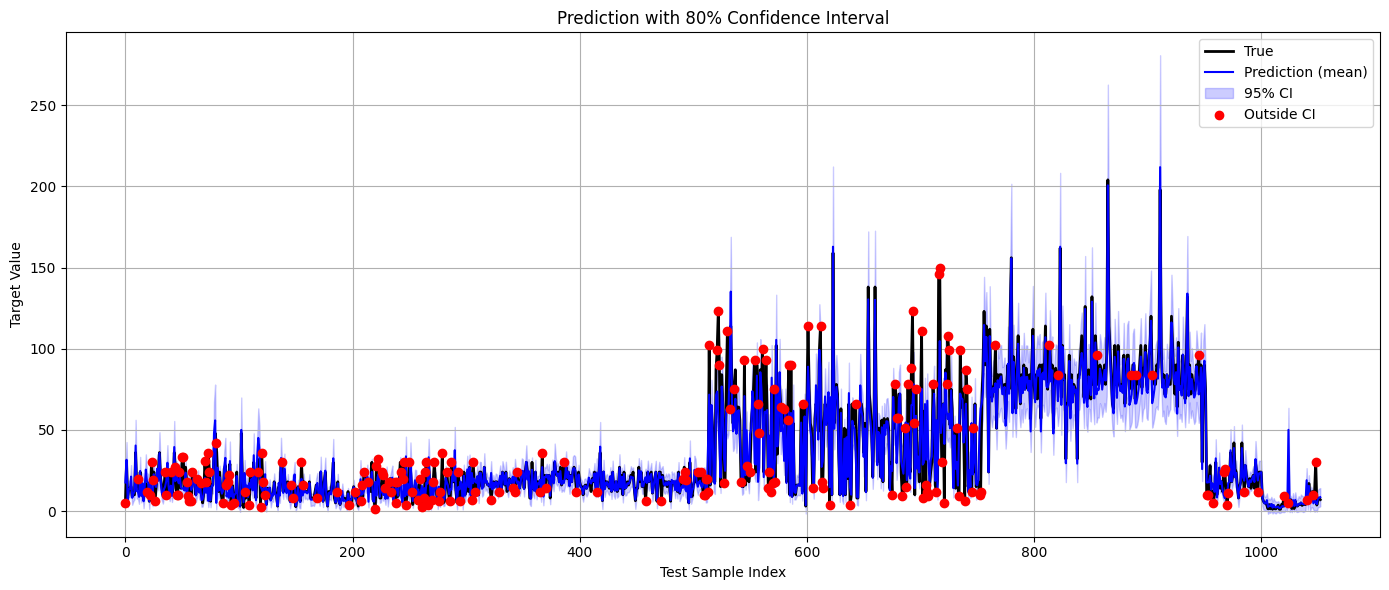

In [25]:
y_true_list = y_test.tolist()
y_preds = mcdropout_df['mean_pred']
ci_bounds = ci_bounds_results['80%']

y_pred_arr = np.array(y_preds)
y_true_arr = np.array(y_true_list)
ci_low_arr = np.array([ci[0] for ci in ci_bounds])
ci_up_arr  = np.array([ci[1] for ci in ci_bounds])
x_axis = np.arange(len(y_true_arr))

plt.figure(figsize=(14, 6))

# Plot prediksi dan ground truth
plt.plot(x_axis, y_true_arr, label='True', color='black', linewidth=2)
plt.plot(x_axis, y_pred_arr, label='Prediction (mean)', color='blue')

# Area Confidence Interval
plt.fill_between(x_axis, ci_low_arr, ci_up_arr, color='blue', alpha=0.2, label='95% CI')

# Titik-titik yang berada di luar CI
out_of_bounds = (y_true_arr < ci_low_arr) | (y_true_arr > ci_up_arr)
plt.scatter(x_axis[out_of_bounds], y_true_arr[out_of_bounds], color='red', label='Outside CI', zorder=5)

plt.title("Prediction with 80% Confidence Interval")
plt.xlabel("Test Sample Index")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
start = 100
end = 150  # inklusif

x_axis = np.arange(start, end + 1)
y_true_part = y_true_arr[start:end+1]
y_pred_part = y_pred_arr[start:end+1]
ci_low_part = ci_low_arr[start:end+1]
ci_up_part = ci_up_arr[start:end+1]

out_of_bounds = (y_true_part < ci_low_part) | (y_true_part > ci_up_part)

fig = go.Figure()

# Plot true values
fig.add_trace(go.Scatter(
    x=x_axis, y=y_true_part,
    mode='lines+markers',
    name='True',
    line=dict(color='black', width=2)
))

# Plot predicted mean
fig.add_trace(go.Scatter(
    x=x_axis, y=y_pred_part,
    mode='lines',
    name='Prediction (mean)',
    line=dict(color='blue')
))

# Plot confidence interval (area)
fig.add_trace(go.Scatter(
    x=np.concatenate([x_axis, x_axis[::-1]]),
    y=np.concatenate([ci_up_part, ci_low_part[::-1]]),
    fill='toself',
    fillcolor='rgba(0,0,255,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=True,
    name='80% CI'
))

# Plot points outside confidence interval
fig.add_trace(go.Scatter(
    x=x_axis[out_of_bounds],
    y=y_true_part[out_of_bounds],
    mode='markers',
    name='Outside CI',
    marker=dict(color='red', size=8, symbol='circle-open')
))

fig.update_layout(
    title='Prediction with 80% Confidence Interval (Samples 100 to 150)',
    xaxis_title='Test Sample Index',
    yaxis_title='Target Value',
    template='plotly_white',
    legend=dict(x=0, y=1)
)

fig.show()
